In [43]:
from chgnet.model.model import CHGNet
from chgnet.model.dynamics import CHGNetCalculator
import json, os 
import torch 
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error


In [3]:
# load the test_results 
results_path = '../Potentials/2024-02-22-100_Train_Results/test_result.json'
data = json.load(open(results_path, 'r'))

In [8]:
print(data[0])

{'mp_id': '2619', 'graph_id': '2619', 'energy': {'ground_truth': -8.672325134277344, 'prediction': -8.667790412902832}, 'force': {'ground_truth': [[0.028077000752091408, 0.008154000155627728, 0.019009999930858612], [0.03156900033354759, 0.013160999864339828, 0.012161999940872192], [0.004296000115573406, -0.004482999909669161, -0.006794000044465065], [0.018098000437021255, -0.00795000046491623, 0.0018919999711215496], [0.0067889997735619545, 0.013717000372707844, 0.01169000007212162], [0.010084999725222588, 0.007311000023037195, 0.002245000097900629], [-0.02100900001823902, 0.0960569977760315, -0.030535999685525894], [-0.008080000057816505, 0.025868000462651253, -0.0033480001147836447], [-0.004490999970585108, -0.009890000335872173, -0.030533000826835632], [0.03200799971818924, 0.004391000140458345, -0.06202799826860428], [0.03427499905228615, 0.00810999982059002, -0.029910000041127205], [-0.00803999975323677, -0.01687300018966198, 0.004466999787837267], [0.010263999924063683, 0.0006830

In [21]:
UNITS_eV = {
    "energy_grad": "eV $\mathdefault{\AA}^{\mathdefault{-1}}$",
    "energy": "eV",
}

def plot_hexbin(pred, targ, ax, key, scale="log", units: dict = UNITS_eV):
    mae = mean_absolute_error(targ, pred)

    if scale == "log":
        pred = np.abs(pred) + 1e-8
        targ = np.abs(targ) + 1e-8

    lim_min = min(np.min(pred), np.min(targ)) * 1.1
    lim_max = max(np.max(pred), np.max(targ)) * 1.1

    extent = [lim_min, lim_max, lim_min, lim_max]

    hb = ax.hexbin(
        pred,
        targ,
        cmap="viridis",
        gridsize=60,
        bins="log",
        mincnt=1,
        edgecolors=None,
        linewidths=(0.1,),
        xscale=scale,
        yscale=scale,
        extent=extent,
    )

    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.set_aspect("equal")

    ax.plot(
        (lim_min, lim_max),
        (lim_min, lim_max),
        color="#000000",
        zorder=-1,
        linewidth=0.5,
    )

    ax.set_xlabel("predicted / %s" % (units[key]), fontsize=12, fontweight="bold")
    ax.set_ylabel("target / %s" % (units[key]), fontsize=12, fontweight="bold")
    ax.annotate(
            "MAE: %.3f %s" % (mae, units[key]),
            (0.03, 0.95),
            xycoords="axes fraction",
            fontsize=12,
            fontweight="bold",
            fontstyle="italic",
        )

    return ax, hb


def stack_cat(item):
    try:
        out = torch.stack(item, dim=0)
    except RuntimeError:
        out = torch.cat(item, dim=0)
    return out

def flatten_forces(forces):
    flattened_list = [item for sublist in forces for item in sublist]
    return flattened_list

In [19]:
results = [dat['force']['prediction'] for dat in data]
targets = [dat['force']['ground_truth'] for dat in data]

In [41]:
flat_results = np.array(list(itertools.chain.from_iterable(itertools.chain.from_iterable(results))))
flat_targets = np.array(list(itertools.chain.from_iterable(itertools.chain.from_iterable(targets))))

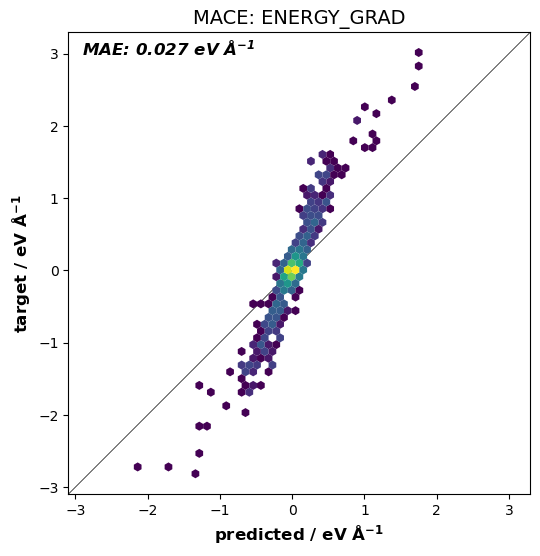

In [44]:
fig, ax = plt.subplots(figsize=(12, 6))
key = "energy_grad"
#pred = stack_cat(results[key]).detach().cpu().numpy().reshape(-1)
#targ = stack_cat(targets[key]).detach().cpu().numpy().reshape(-1)


plot_hexbin(flat_results, flat_targets, ax, key, scale="linear")

ax.set_title("%s: %s" % ("MACE", key.upper()), fontsize=14)

plt.show()

In [47]:
from ase.io import read

data = read('../Archived_Vasp_Jobs/OUTCAR-1', format='vasp-out', index=':')